In [1]:
!pip install spectral
#import argparse
# Loading Drive for Colab
from google.colab import drive
from google.colab import files
## Basics
import gc
gc.collect()
import warnings
warnings.filterwarnings('ignore')
import urllib
import urllib.request
import time
import numpy
import numpy as np
from PIL import Image
from operator import truediv
import scipy.io as sio
import os
import pandas as pd
import seaborn as sns
##import seaborn as sn
import spectral
## Ploting
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline
## Sklearn
from sklearn import preprocessing
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.decomposition import PCA
## Deep Model
import h5py
from tensorflow.keras import models, layers
from keras.utils.vis_utils import plot_model
import keras
from keras.layers import Input, concatenate, Dropout, Conv2D, Conv3D, Flatten, Dense, Reshape, Activation, ZeroPadding2D, SeparableConv2D, MaxPooling3D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, GlobalAveragePooling3D
from keras.losses import categorical_crossentropy
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Mounting the Colab Drive for Loading Datasets
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
## Downloading (if not avaialbe) and Loading Hyperspectral Datasets
def LoadHSIData(method):
  ## Downloading Hyperspectral Datasets (Please Retry, if Link error appear)
    HSI_url = ['http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat',
               'http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat']
    for i in range(2):
        file_name = HSI_url[i].split('/')[-1]
        data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/Colab'+str(file_name))
        if os.path.exists(data_path) == False:
            print("Downloading data file from %s to %s" % (HSI_url[i], data_path))
            urllib.request.urlretrieve(url=HSI_url[i], filename=data_path)
            print(str(file_name)+" is Successfully downloaded")
        else:
            print(str(file_name) + " already exists")
    print('HSI dataset exist!')
    ## Loading Datasets
    data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/Colab')
    if method == 'IP':
        HSI = sio.loadmat(os.path.join(data_path, 'ColabIndian_pines_corrected.mat'))['indian_pines_corrected']
        GT = sio.loadmat(os.path.join(data_path, 'ColabIndian_pines_gt.mat'))['indian_pines_gt']
        Num_Classes = 16
    return HSI, GT, Num_Classes

In [4]:
## Split Training, Validation and Test Sets
def TrTeSplit(HSI, GT, testRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size = testRatio,
                                        random_state = randomState,
                                        stratify = GT)
    return Tr, Te, TrC, TeC

In [5]:
## Global Parameters for Loop
HSID = "IP"
WS = 11
k = 15
adam = Adam(lr = 0.0001, decay = 1e-06)
epochs = 50
batch_size = 256

In [6]:
## 3-D HSI slices
def ImageCubes(HSI, GT, WS = WS, removeZeroLabels = True):
    margin = int((WS - 1) / 2)
    zeroPaddedX = ZeroPad(HSI, margin = margin)
    ## split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WS, WS, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
## Padding around HSI
def ZeroPad(HSI, margin = 2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI
## Compute the Patch to Prepare for Ground Truths
def Patch(HSI,height_index,width_index):
    height_slice = slice(height_index, height_index+WS)
    width_slice = slice(width_index, width_index+WS)
    patch = HSI[height_slice, width_slice, :]
    return patch

In [7]:
## Assigning Class Labels for Final Classification
def ClassificationReports(TeC, DataName, Te_Pred):
    Te_Pred = np.argmax(Te_Pred, axis=1)
    if DataName == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings',
                        'Stone-Steel']
    classification = classification_report(np.argmax(TeC, axis=1), Te_Pred, target_names = target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), Te_Pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), Te_Pred)
    list_diag = np.diag(confusion)
    list_raw_sum = np.sum(confusion, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    aa = np.mean(each_acc)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), Te_Pred)
    return classification, confusion, oa*100, each_acc*100, aa*100, kappa*100, target_names

In [8]:
## Main Function to load Datasets, and Creating Patchs for CNN
HSI, GT, Num_Classes = LoadHSIData(HSID)
## Reduce the Dimensionality
start = time.time()
RDHSI = np.reshape(HSI, (-1, HSI.shape[2]))
pca = PCA(n_components = k, whiten = True)
RDHSI = pca.fit_transform(RDHSI)
RDHSI = np.reshape(RDHSI, (HSI.shape[0], HSI.shape[1], k))
end = time.time()
DL_Time = end - start
## Create Image Cubes for Model Building
CRDHSI, CGT = ImageCubes(RDHSI, GT, WS = WS)
## Split Train/Validation and Test
Tr, Te, TrC, TeC = TrTeSplit(CRDHSI, CGT, 0.1)
Tr, Va, TrC, VaC = TrTeSplit(Tr, TrC, 0.5)
Tr = Tr.reshape(-1, WS, WS, k, 1)
TrC = np_utils.to_categorical(TrC)
Va = Va.reshape(-1, WS, WS, k, 1)
VaC = np_utils.to_categorical(VaC)
Te = Te.reshape(-1, WS, WS, k, 1)
TeC = np_utils.to_categorical(TeC)

Indian_pines_corrected.mat already exists
Indian_pines_gt.mat already exists
HSI dataset exist!


In [9]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

def entry_flow(inputs):
    x = Conv3D(filters=32, kernel_size=(5, 5, 3), activation='relu', padding = 'same')(inputs)
    x = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding = 'same')(x)
    previous_block_activation = x
    for size in [128, 256, 512]:
        x = Conv2Plus1D(filters=size, kernel_size=(3, 3, 3), padding='same')(x)
        x = Conv2Plus1D(filters=size, kernel_size=(3, 3, 3), padding='same')(x)
        x = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
        residual = Conv3D(size, kernel_size=(3, 3, 3), strides = (3, 3, 3), padding = 'same')(previous_block_activation)
        x = keras.layers.Add()([x, residual])
        previous_block_activation = x
    return x

def middle_flow(x, num_blocks = 8):
    previous_block_activation = x
    for _ in range(num_blocks):
        x = Conv2Plus1D(filters=128, kernel_size=(5, 3, 3), padding='same')(x)
        x = Conv2Plus1D(filters=256, kernel_size=(5, 3, 3), padding='same')(x)
        x = Conv2Plus1D(filters=512, kernel_size=(5, 3, 3), padding='same')(x)
        x = keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    return x

def exit_flow(x) :
    previous_block_activation = x
    x = Conv2Plus1D(filters=512, kernel_size=(3, 3, 3), padding='same')(x)
    x = Conv2Plus1D(filters=728, kernel_size=(3, 3, 3), padding='same')(x)
    x = MaxPooling3D(pool_size=(3, 3, 3), padding = 'same')(x)
    residual = Conv3D(728, kernel_size=(3, 3, 3), padding = 'same')(previous_block_activation)
    x = keras.layers.Add()([x, residual])
    x = Conv2Plus1D(filters=512, kernel_size=(3, 3, 3), padding='same')(x)
    x = Conv2Plus1D(filters=256, kernel_size=(3, 3, 3), padding='same')(x)
    x = Dropout(0.4)(x)
    x = GlobalAveragePooling3D()(x)
    x = Dense(Num_Classes, activation='softmax')(x)
    return x

In [10]:
inputs = Input(shape=(WS, WS, k, 1))
inputs.shape
outputs = exit_flow(middle_flow(entry_flow(inputs)))
model = Model(inputs, outputs)
## Compile Model
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
start = time.time()
history_Xception_3D = model.fit(Tr, TrC, epochs=epochs, batch_size=batch_size, validation_data=(Va, VaC))
end = time.time()
Tr_Time = end - start
## Prediction Model
start = time.time()
Te_Pred = model.predict(Te)
end = time.time()
Te_Time = end - start
## Computing and Writing the Accuacy
classification,confusion,oa,each_acc,aa,kappa,target_names = ClassificationReports(TeC, HSID, Te_Pred)
print(classification)
print(each_acc)

Epoch 1/50
19/19 [==============================] - 39s 1s/step - loss: 2.5571 - accuracy: 0.1975 - val_loss: 2.3715 - val_accuracy: 0.2394
Epoch 2/50
19/19 [==============================] - 18s 944ms/step - loss: 2.3397 - accuracy: 0.2374 - val_loss: 2.2478 - val_accuracy: 0.2411
Epoch 3/50
19/19 [==============================] - 16s 848ms/step - loss: 2.2024 - accuracy: 0.2348 - val_loss: 2.0407 - val_accuracy: 0.2582
Epoch 4/50
19/19 [==============================] - 16s 848ms/step - loss: 1.9792 - accuracy: 0.2897 - val_loss: 1.6552 - val_accuracy: 0.4005
Epoch 5/50
19/19 [==============================] - 16s 855ms/step - loss: 1.4971 - accuracy: 0.4623 - val_loss: 1.2498 - val_accuracy: 0.5609
Epoch 6/50
19/19 [==============================] - 16s 866ms/step - loss: 1.2094 - accuracy: 0.5540 - val_loss: 1.1340 - val_accuracy: 0.6195
Epoch 7/50
19/19 [==============================] - 17s 933ms/step - loss: 1.0834 - accuracy: 0.6119 - val_loss: 0.8594 - val_accuracy: 0.6841
Ep

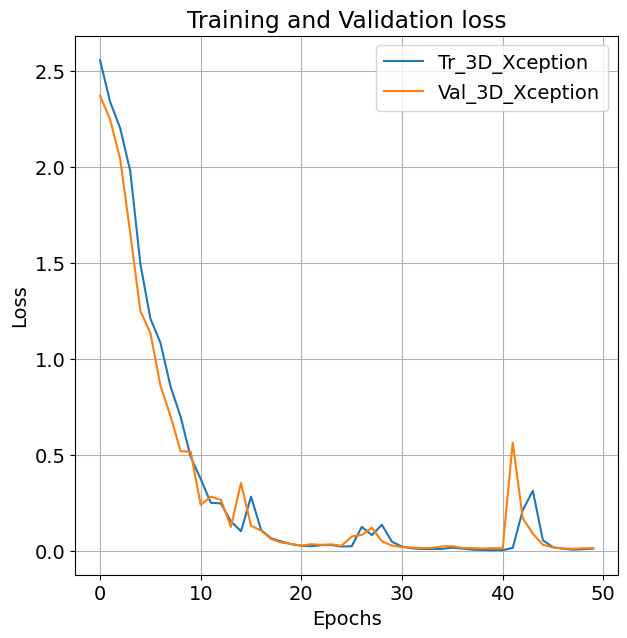

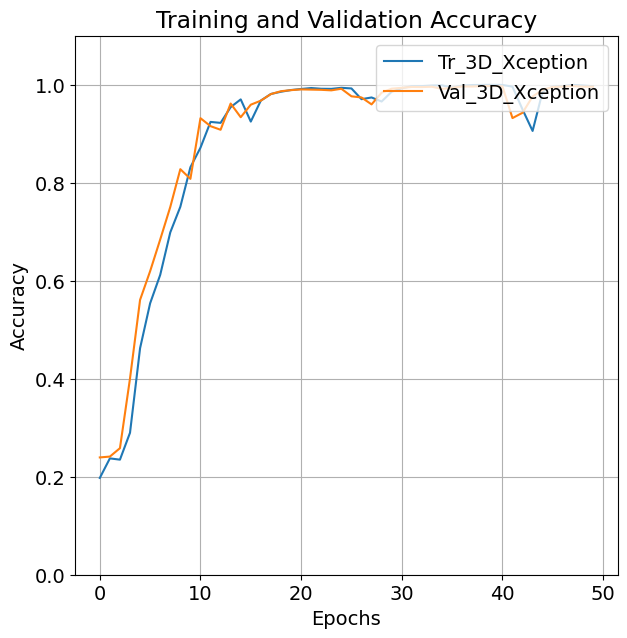

In [11]:
## Draw Training/Validation Loss and Accuracy
plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 14})
plt.grid()
plt.plot(history_Xception_3D.history['loss'])
plt.plot(history_Xception_3D.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation loss')
plt.legend(['Tr_3D_Xception', 'Val_3D_Xception'], loc='upper right')
plt.show()
## Plot Training and Validation Accuracy
plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history_Xception_3D.history['accuracy'])
plt.plot(history_Xception_3D.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend(['Tr_3D_Xception', 'Val_3D_Xception',
            'Tr_2D_Xception','Val_2D_Xception'], loc='upper right')